In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import umap

if not os.path.exists("Figures"):
    os.mkdir("Figures")


def plot_umap_categorical(feature, data, save_as=None, dpi=600, alpha=0.6, s=3):
    top_categories = data[feature].value_counts().nlargest(10).index
    # Only replace categories not in the top 10 and not NA/N/A
    data[f"{feature}_top_categories"] = data[feature].apply(
        lambda x: x if x in top_categories or pd.isna(x) else "Other"
    )
    # Create the plot
    plt.figure(figsize=(7, 6))
    scatter = sns.scatterplot(
        x="UMAP1",
        y="UMAP2",
        hue=f"{feature}_top_categories",
        data=data,
        palette="tab20",
        alpha=alpha,
        s=s,
        edgecolor="none",
    )
    plt.title(f"UMAP of Sample Embeddings Colored by Top 10 {feature}")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    
    # Modify legend
    plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc="upper left", markerscale=3)
    
    # Save the plot
    if save_as:
        plt.savefig(save_as, bbox_inches="tight", dpi=dpi)
    plt.show()
# Function to plot UMAP with a numerical feature
def plot_umap_numerical(feature, data, save_as=None, dpi=600, alpha=0.6, s=3):
    # Convert to numeric and handle NA/N/A
    data[feature] = pd.to_numeric(data[feature], errors="coerce")

    # Create the plot
    plt.figure(figsize=(7, 6))
    plt.scatter(
        data["UMAP1"],
        data["UMAP2"],
        c=data[feature],
        cmap="viridis",
        alpha=alpha,
        s=s,
        edgecolor="none",
    )
    plt.colorbar(label=feature)
    plt.title(f"UMAP of Sample Embeddings Colored by {feature}")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")

    # Save the plot
    if save_as:
        plt.savefig(save_as, bbox_inches="tight", dpi=dpi)
    plt.show()
    

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

## Read all metadata
metadata_path = "metadata/gpt-4-1106-preview_output"
column_names = [
    "GSM_ID",
    "PATIENT_ID",
    "race",
    "sex",
    "age",
    "genetic_info",
    "disease",
    "tissue",
    "cell_line",
    "vivo_vitro",
    "case_control",
    "group_name",
    "treatment",
    "perturbation_category",
]

# Initialize an empty DataFrame to hold all data
dataframes = []  # List to hold individual dataframes

# Iterate over each file in the directory
for filename in os.listdir(metadata_path):
    if filename.endswith(".dsv"):
        file_path = os.path.join(metadata_path, filename)
        # Read the file and add it to the list
        df = pd.read_csv(file_path, sep="|", names=column_names, header=None)
        dataframes.append(df)


# Concatenate all dataframes in the list into a single dataframe
compiled_data = pd.concat(dataframes, ignore_index=True)
compiled_data = compiled_data[compiled_data["tissue"] != "NA"]
##
write_path = "compiled_metadata.csv.gz"
compiled_data.to_csv(write_path, index=False, compression="gzip")
##
compiled_data = pd.read_csv("compiled_metadata.csv.gz")

/usr/local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


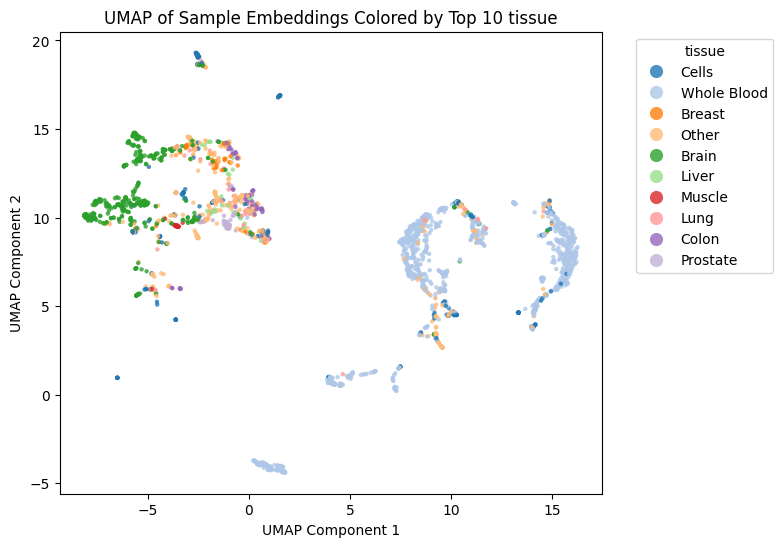

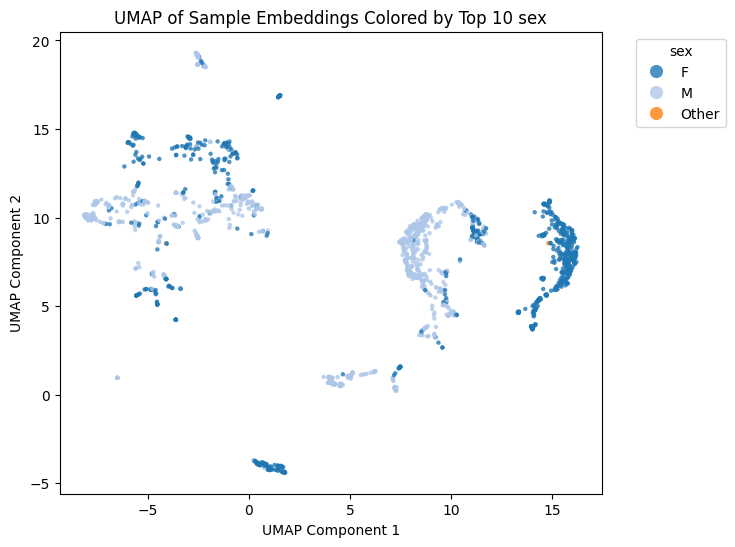

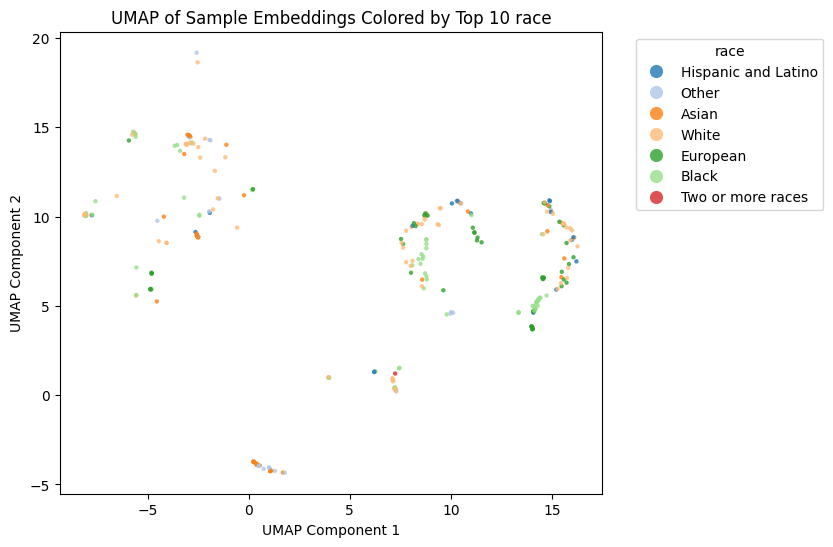

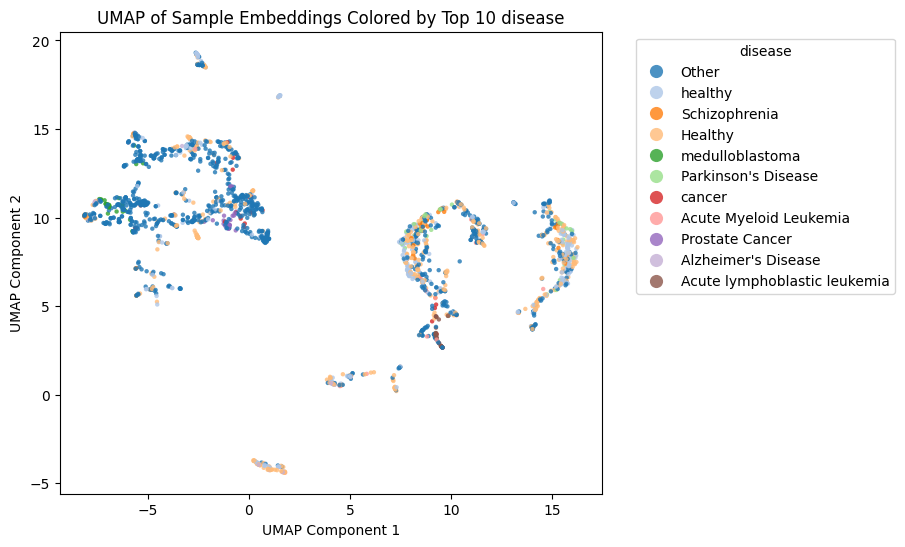

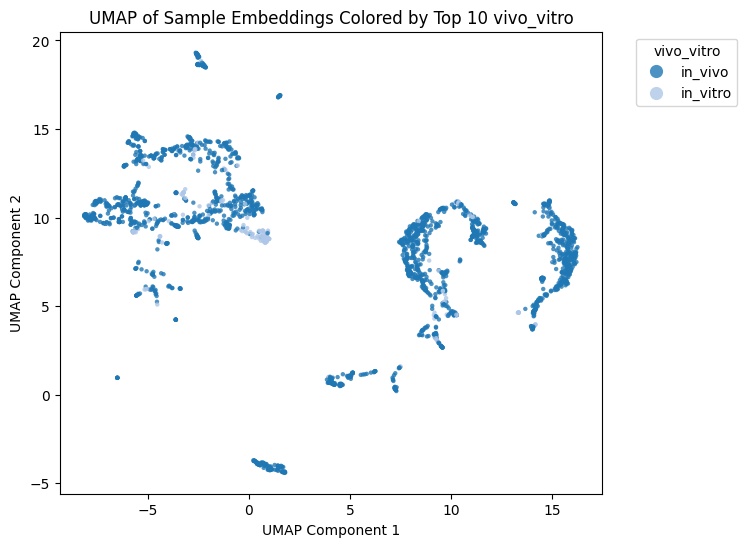

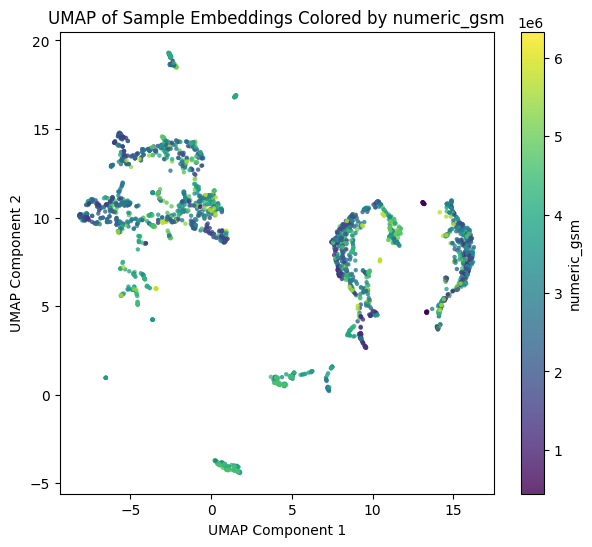

In [3]:

##
# Read valid_cell_emb.pt pickle file
with open("Embeddings/cell_emb.pt", "rb") as f:
    valid_cell_emb = pickle.load(f)

# Run UMAP on valid_cell_emb
valid_cell_emb_np = valid_cell_emb["cell_emb"]
valid_umap_model = umap.UMAP(n_components=2, random_state=42)
valid_umap_emb = valid_umap_model.fit_transform(valid_cell_emb_np)
cell_list = valid_cell_emb["cell_list"]
umap_emb = valid_umap_emb


cell_emb_df = pd.DataFrame(umap_emb, index=cell_list)
cell_emb_df.reset_index(inplace=True)
cell_emb_df.columns = ["GSM_ID", "UMAP1", "UMAP2"]

merged_data = pd.merge(compiled_data, cell_emb_df, on="GSM_ID")

merged_data["numeric_gsm"] = merged_data["GSM_ID"].apply(lambda x: int(x[3:]))

##


##

plot_umap_categorical(
    "tissue",
    merged_data,
    save_as="Figures/embeding_tissue_Aug29-11-38.png",
    s=10,
    alpha=0.8,
)

plot_umap_categorical(
    "sex",
    merged_data,
    save_as="Figures/embeding_sex_Aug29-11-38.png",
    s=10,
    alpha=0.8,
)

plot_umap_categorical(
    "race",
    merged_data,
    save_as="Figures/embeding_race_Aug29-11-38.png",
    s=10,
    alpha=0.8,
)

plot_umap_categorical(
    "disease",
    merged_data,
    save_as="Figures/embeding_disease_Aug29-11-38.png",
    s=10,
    alpha=0.8,
)

plot_umap_categorical(
    "vivo_vitro",
    merged_data,
    save_as="Figures/embeding_vivo_vitro_Aug29-11-38.png",
    s=10,
    alpha=0.8,
)

plot_umap_numerical(
    "numeric_gsm",
    merged_data,
    save_as="Figures/embeding_numeric_gsm_Aug29-11-38.png",
    s=10,
    alpha=0.8,
)



In [4]:
'''

## for training set

with open("results/embeddings/train_cell_emb.pt", "rb") as f:
    train_cell_emb = pickle.load(f)

# Run UMAP on train_cell_emb
train_cell_emb_np = train_cell_emb["cell_emb"]
train_umap_model = umap.UMAP(n_neighbors = 100, n_components=2, random_state=42)
train_umap_emb = train_umap_model.fit_transform(train_cell_emb_np)
cell_list = train_cell_emb["cell_list"]
umap_emb = train_umap_emb

cell_emb_df = pd.DataFrame(umap_emb, index=cell_list)
# colums = ["UMAP1", "UMAP2"]
cell_emb_df.reset_index(inplace=True)
# set column name to GSM_ID, UMAP1, UMAP2
cell_emb_df.columns = ["GSM_ID", "UMAP1", "UMAP2"]

merged_data = pd.merge(compiled_data, cell_emb_df, on="GSM_ID")


plot_umap_categorical(
    "disease",
    merged_data,
    save_as="figures/embeding_disease_train_Aug29-11-38.png",
)

plot_umap_categorical(
    "tissue",
    merged_data,
    save_as="figures/embeding_tissue_train_Aug29-11-38.png",
)'''

'\n\n## for training set\n\nwith open("results/embeddings/train_cell_emb.pt", "rb") as f:\n    train_cell_emb = pickle.load(f)\n\n# Run UMAP on train_cell_emb\ntrain_cell_emb_np = train_cell_emb["cell_emb"]\ntrain_umap_model = umap.UMAP(n_neighbors = 100, n_components=2, random_state=42)\ntrain_umap_emb = train_umap_model.fit_transform(train_cell_emb_np)\ncell_list = train_cell_emb["cell_list"]\numap_emb = train_umap_emb\n\ncell_emb_df = pd.DataFrame(umap_emb, index=cell_list)\n# colums = ["UMAP1", "UMAP2"]\ncell_emb_df.reset_index(inplace=True)\n# set column name to GSM_ID, UMAP1, UMAP2\ncell_emb_df.columns = ["GSM_ID", "UMAP1", "UMAP2"]\n\nmerged_data = pd.merge(compiled_data, cell_emb_df, on="GSM_ID")\n\n\nplot_umap_categorical(\n    "disease",\n    merged_data,\n    save_as="figures/embeding_disease_train_Aug29-11-38.png",\n)\n\nplot_umap_categorical(\n    "tissue",\n    merged_data,\n    save_as="figures/embeding_tissue_train_Aug29-11-38.png",\n)'